# Machine Learning Engineer Nanodegree

## Unsupervised Learning Project: Creating Customer Segments

## 1 Introduction

In this project, we analyze a dataset containing data on various customers' annual spending amounts of diverse product categories for internal structure. The goal is to best describe the variation in the different types of customers that the wholesale distributor interacts with. With this information the retailer would be able to better assess how future proposed changes to their services would affect different types of customers.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers).

In [1]:
# Check Python version

import sys
print (sys.version)

2.7.13 |Anaconda 4.3.1 (x86_64)| (default, Dec 20 2016, 23:05:08) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


In [2]:
# Import libraries

import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
import sklearn

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from IPython.display import display # Allows the use of display() for DataFrames
from IPython.display import Markdown

# Show matplotlib plots inline
%matplotlib inline
%pylab inline

print('scikit-learn version is {}.'.format(sklearn.__version__))
print('NumPy version is {}.'.format(np.__version__))
print('SciPy version is {}.'.format(sp.__version__))

Populating the interactive namespace from numpy and matplotlib
scikit-learn version is 0.20.0.
NumPy version is 1.15.2.
SciPy version is 1.1.0.


In [3]:
# Load the wholesale customers dataset

try:
    data = pd.read_csv("customers.csv")
    # For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis,
    # we focus instead on the six product categories recorded for customers.
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

(n_samples, n_features) = data.shape
features = data.keys()

Wholesale customers dataset has 440 samples with 6 features each.


## 2 Data Exploration

In [4]:
# Display a description of the dataset

display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### 2.1 Selecting Samples

To get a better understanding of the customers and how their data will transform through the analysis, we select a few sample data points and explore them in more detail. We look for three customers that vary significantly from one another.

In [5]:
# Find customers with the min and max total spends

total_spend = data.sum(axis=1)
min_spender = total_spend.argmin()
min_spend = total_spend.min()
max_spender = total_spend.argmax()
max_spend = total_spend.max()
print "min spender:" , min_spender , "min spend:" , min_spend
print "max spender:" , max_spender , "max spend:" , max_spend, "\n"


# Find customers with the min and max spend for each category

min_spender_per_category = data.idxmin(axis=0)
max_spender_per_category = data.idxmax(axis=0)

print "min spenders:"
print min_spender_per_category, "\n"
print "max spenders:"
print max_spender_per_category, "\n"


# Find how many customers had their min and max spends in each category

min_spend_category = data.idxmin(axis=1)
max_spend_category = data.idxmax(axis=1)

print "min spend category count:"
print min_spend_category.value_counts(), "\n"
print "max spend category count:" 
print max_spend_category.value_counts(), "\n"

min spender: 154 min spend: 904
max spender: 85 max spend: 199891 

min spenders:
Fresh                95
Milk                154
Grocery              75
Frozen              420
Detergents_Paper     75
Delicatessen        109
dtype: int64 

max spenders:
Fresh               181
Milk                 86
Grocery              85
Frozen              325
Detergents_Paper     85
Delicatessen        183
dtype: int64 

min spend category count:
Detergents_Paper    192
Delicatessen        132
Frozen               95
Fresh                17
Milk                  3
Grocery               1
dtype: int64 

max spend category count:
Fresh               246
Grocery             126
Milk                 42
Frozen               22
Delicatessen          3
Detergents_Paper      1
dtype: int64 



In [6]:
# Very few (4) customers have their min spend categories as Milk (3) / Grocery (1)
# Very few (4) customers have their max spend categories as Deli (3) / Detergents (1)
# who are they?

for i in xrange(0,n_samples):
    if min_spend_category[i]=='Grocery':
       print 'min Grocery', i
    if min_spend_category[i]=='Milk':
       print 'min Milk', i
    if max_spend_category[i]=='Detergents_Paper':
       print 'max Detergents_Paper', i
    if max_spend_category[i]=='Delicatessen':
       print 'max Delicatessen', i

min Milk 22
min Milk 71
min Grocery 75
max Delicatessen 183
min Milk 186
max Detergents_Paper 228
max Delicatessen 372
max Delicatessen 411


,max spend category,min spend category,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
22,Fresh,Milk,31276,1917,4469,9408,2381,4334
71,Grocery,Milk,18291,1266,21042,5373,4173,14472
75,Fresh,Grocery,20398,1137,3,4407,3,975
85,Grocery,Frozen,16117,46197,92780,1026,40827,2944
86,Milk,Delicatessen,22925,73498,32114,987,20070,903
154,Fresh,Detergents_Paper,622,55,137,75,7,8
183,Delicatessen,Detergents_Paper,36847,43950,20170,36534,239,47943
186,Frozen,Milk,3009,521,854,3470,949,727
228,Detergents_Paper,Delicatessen,1869,577,572,950,4762,203
372,Delicatessen,Detergents_Paper,3884,3801,1641,876,397,4829


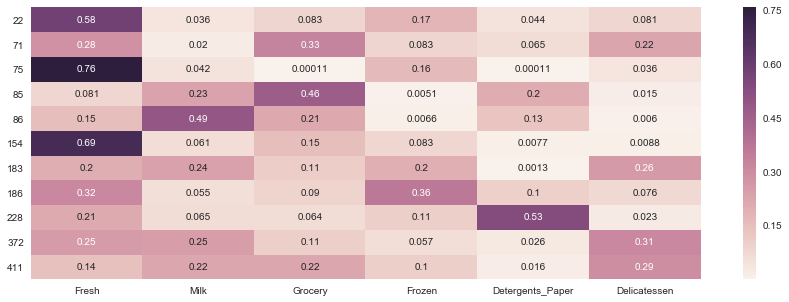

In [7]:
# Put the customers/indices we're interested in a data frame

indices_of_interest = [22, 71, 75, 85, 86, 154, 183, 186, 228, 372, 411]

minmax_df = pd.DataFrame(
    {'min spend category': min_spend_category.iloc[indices_of_interest],
     'max spend category': max_spend_category.iloc[indices_of_interest]},
    index=indices_of_interest)
samples_df = data.loc[indices_of_interest]

display(minmax_df.join(samples_df))


# Let's look at the spending for each of these customers as a proportion of their total 

samples2_df = samples_df.divide(samples_df.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(15,5))
ax = sns.heatmap(samples2_df, annot=True)
plt.yticks(rotation=0)
plt.show()

In [8]:
# We select the three customers with the following indices

indices = [85, 228, 372]


# Create a DataFrame of the chosen samples

samples = data.loc[indices]
print "Chosen samples of wholesale customers dataset:"
display(samples)

display(data.describe().loc[['mean', '25%', '50%', '75%']].round(1))


# Look at where in the distribution of spending for each category our samples lie

# sample_percentiles = data.loc[indices]

# for feature in features:
#     for i in indices:
#         sample_percentiles[feature].loc[i] = stats.percentileofscore(data[feature], samples[feature].loc[i], kind='rank')
# display(sample_percentiles.round(decimals=1))

# There's a nicer way of doing this
display(100.0 * data.rank(axis=0, pct=True).iloc[indices].round(decimals=3))

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
85,16117,46197,92780,1026,40827,2944
228,1869,577,572,950,4762,203
372,3884,3801,1641,876,397,4829


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
mean,12000.3,5796.3,7951.3,3071.9,2881.5,1524.9
25%,3127.8,1533.0,2153.0,742.2,256.8,408.2
50%,8504.0,3627.0,4755.5,1526.0,816.5,965.5
75%,16933.8,7190.2,10655.8,3554.2,3922.0,1820.2


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
85,73.2,99.5,100.0,36.8,100.0,90.0
228,15.7,4.4,2.7,35.0,80.5,11.1
372,28.4,53.2,15.0,31.4,35.3,95.5


#### Summary of chosen customers

Below we list the product categories, in descending order of distribution percentile, that each customer in our sample purchased

<u>Spending amounts as a percentile of the distribution for customer **index 85**</u>:

| Grocery   | Detergents_Paper | Milk      | Delicatessen | Fresh     | Frozen    |
|-----------|------------------|-----------|--------------|-----------|-----------|
| 99.886364 | 99.886364        | 99.431818 | 89.886364    | 73.068182 | 36.704545 |

The first customer in our sample (index 85) is the highest spending customer overall. Their spending is above the 99th percentile on product categories Grocery, Detergents_Paper and Milk, less so on Delicatessen and Fresh products and well below the median on Frozen. I would guess this customer might be a **convenience store**.

<u>Spending amounts as a percentile of the distribution for customer **index 228**</u>:

| Detergents_Paper | Frozen    | Fresh     | Delicatessen | Milk     | Grocery  |
|------------------|-----------|-----------|--------------|----------|----------|
| 80.340909        | 34.886364 | 15.568182 | 11.022727    | 4.318182 | 2.613636 |

The second customer in our sample (index 228) is the only customer who's highest spending category is Detergents_Paper. Their spending on this category is above the 80th percentile and below the 35th percentile on all other product categories. In fact this customer spends more on Detergent_Paper than all other product categories combined. I would guess this customer to be a (very clean ;) **guesthouse**.

<u>Spending amounts as a percentile of the distribution for customer **index 372**</u>:

| Delicatessen | Milk      | Detergents_Paper | Frozen    | Fresh     | Grocery   |
|--------------|-----------|------------------|-----------|-----------|-----------|
| 95.340909    | 53.068182 | 35.227273        | 31.250000 | 28.295455 | 14.886364 |

The third and final customer in our sample (index 372) is one of only three customers whose highest spending category is Delicatessen. Their spending on this product category is above the 95th percentile, above the 53rd percentile for Milk and below the 36th percentile on all other categories. I would guess this customer to be a **sandwich shop**.

### 2.2 Feature Relevance

Here we check if it is possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We do this by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In [9]:
# For each feature we make a copy of the DataFrame, using the 'drop' function to drop the feature
# we then try to predict that feature from the others using a decision tree regressor

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

for feature in features:

    new_data = data.drop(feature, axis=1)
    target = data[feature]

    # Split the data into training and testing sets using the given feature as the target
    X_train, X_test, y_train, y_test = train_test_split(new_data, target, test_size=0.25, random_state=0)

    # Create a decision tree regressor and fit it to the training set
    regressor = DecisionTreeRegressor(random_state=0)
    regressor.fit(X_train, y_train)

    # Report the score of the prediction using the testing set
    score = regressor.score(X_test, y_test)
    print "Prediction score for", feature, "is", score

Prediction score for Fresh is -0.2524698076882732
Prediction score for Milk is 0.36572529273630905
Prediction score for Grocery is 0.6028019788784589
Prediction score for Frozen is 0.2539734466970086
Prediction score for Detergents_Paper is 0.7286551812541454
Prediction score for Delicatessen is -11.663687159428036


R<sup>2</sup> score for each feature when we try to predict its value from the other five features. We have ordered them in descending order of relevance.

**Table 2.2:** Feature Relevance

| Target                  | Delicatessen | Fresh | Frozen | Milk | Grocery | Detergents_Paper |
|-------------------------|--------------|-------|--------|------|---------|------------------|
| **R<sup>2</sup> score** | -11.66       | -0.25 | 0.25   | 0.37 | 0.60    | 0.73             |

### 2.3 Visualize Feature Distributions

To get a better understanding of the dataset, we construct a scatter matrix of each of the six product features present in the data. 

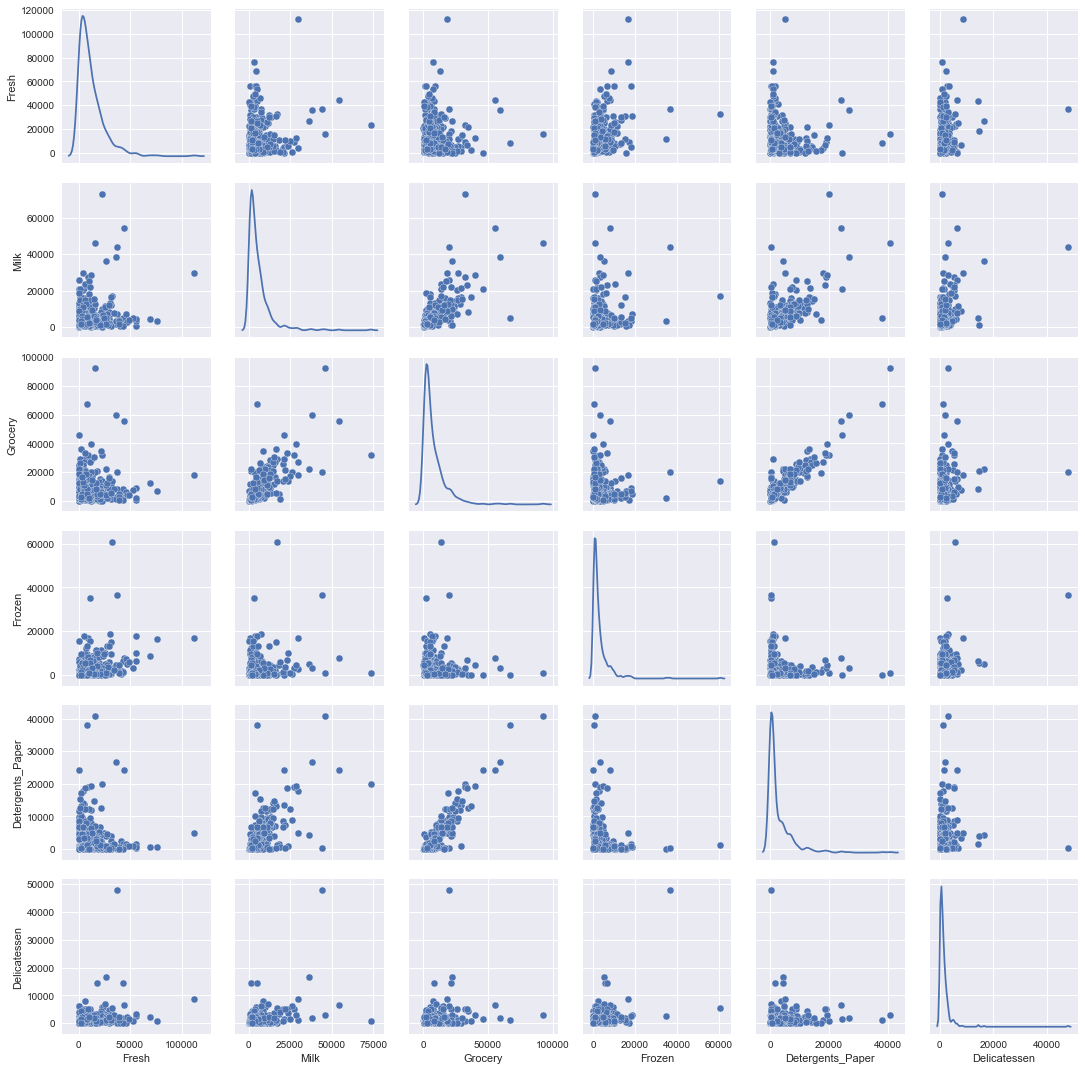

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
mean,12000.0,5796.0,7951.0,3072.0,2881.0,1525.0
50%,8504.0,3627.0,4756.0,1526.0,816.0,966.0


In [11]:
# Produce a scatter matrix for each pair of features in the data

#pd.scatter_matrix(data, alpha = 0.3, figsize = (14,10), diagonal = 'kde');
sns.pairplot(data, diag_kind='kde')
plt.show()

display(data.describe().loc[['mean','50%']].round())

#### Analysis of scatter matrix

Spending on the following product categories appear to be positively correlated with each other (that is all 3 possible pairs)

* Detergents_Paper,
* Grocery,
* Milk.

We note further that our these correlations are qualitatively consistent with the results for R<sup>2</sup> in the Table 2.2.

From the plots, the data for these features appears to be log-normally distributed. In particular, the data is positively skewed; most data points are at the lower end with a few very high valued data points and Median << Mean.

## 3 Data Preprocessing

### 3.1 Feature Scaling

Since the data is not normally distributed and the mean and median vary significantly (indicating a large skew), we apply a non-linear scaling. This is [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) for financial data.

One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. We take a simpler approach which works in most cases and apply the natural logarithm.

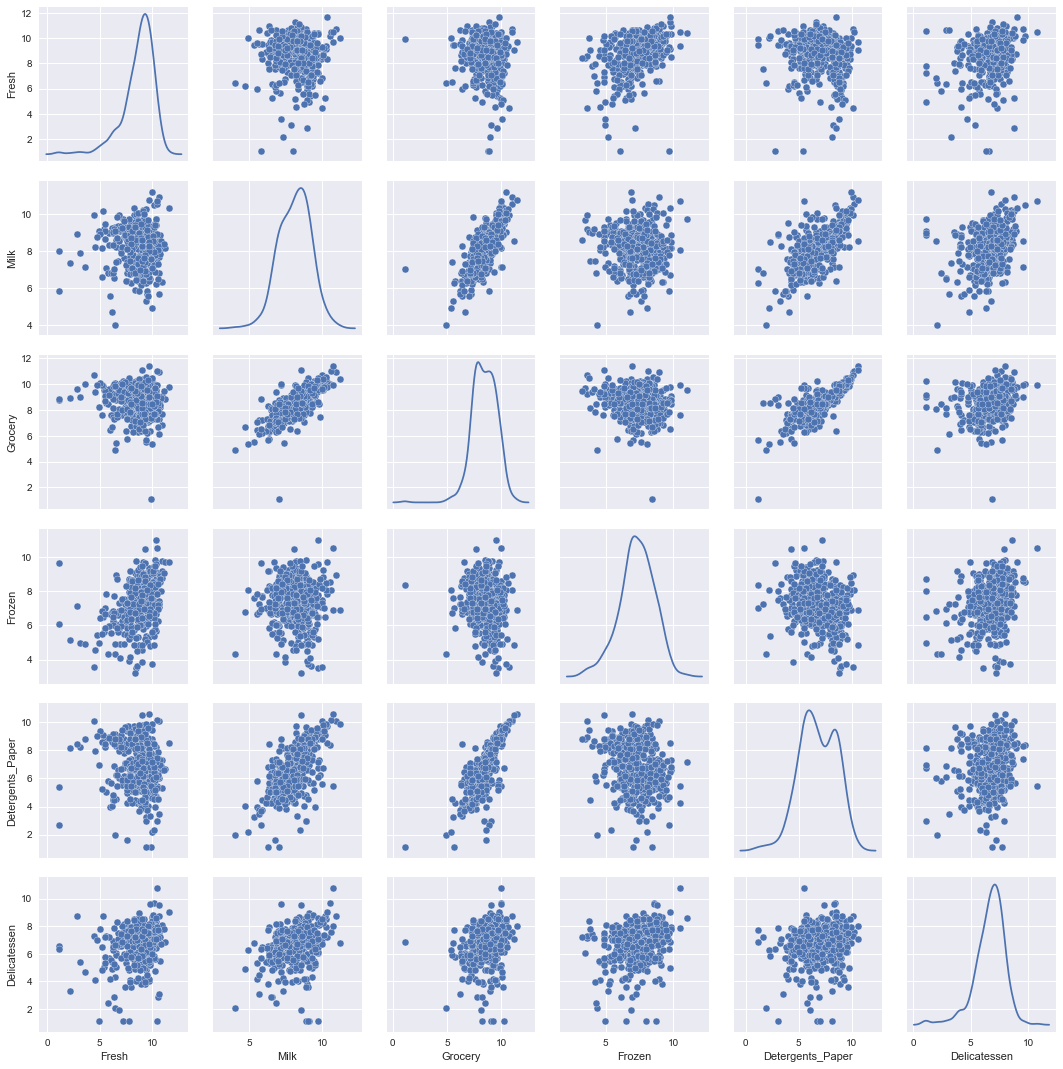

In [12]:
# Scale the data using the natural logarithm
log_data = np.log(data.copy())

# Scale the sample data using the natural logarithm
log_samples = np.log(samples.copy())

# Produce a scatter matrix for each pair of newly-transformed features
# pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,10), diagonal = 'kde')
sns.pairplot(log_data, diag_kind='kde')
plt.show()

#### Observation

After applying a natural logarithm scaling to the data, the distribution of each feature appears much more normal. For the pairs of features we identified earlier as being correlated,

* Detergents_Paper,
* Grocery &
* Milk,

we observe those correlations are still present and stronger than before.

We also note that many od the distributions appear to be bi-modal.

In [13]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
85,9.687630,10.740670,11.437986,6.933423,10.617099,7.987524
228,7.533159,6.357842,6.349139,6.856462,8.468423,5.313206
372,8.264621,8.243019,7.403061,6.775366,5.983936,8.482395


### 3.2 Outlier Detection

The presence of outliers can often skew results which take these data points into consideration. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In [14]:
# For each feature find the data points with extreme high or low values
for feature in features:
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*( Q3 - Q1 )
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


In [15]:
# Compare mean and median for log_data
display(log_data.describe().loc[['mean', '50%']])

all_outliers = [ 38,  57,  65,  66,  75,  81,  86,  95,  96,  98,
                109, 128, 137, 142, 145, 154, 161, 171, 175,
                183, 184, 187, 193, 203, 218, 233, 264, 285, 289,
                304, 305, 325, 338, 343, 353, 355, 356, 357,
                412, 420, 429, 439]

# Look at how much these outliers spend
print 'These outliers spend' , total_spend[all_outliers].sum() , '/' , total_spend.sum() , '=' , total_spend[all_outliers].astype(float).sum()/total_spend.astype(float).sum() , 'of the total.'


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
mean,8.730544,8.121047,8.441169,7.301396,6.785972,6.665133
50%,9.048286,8.196159,8.467057,7.330388,6.705018,6.872645


These outliers spend 1632460 / 14619500 = 0.111663189576 of the total.


These outliers spend 621013 / 14619500 = 0.0424784021341 of the total.


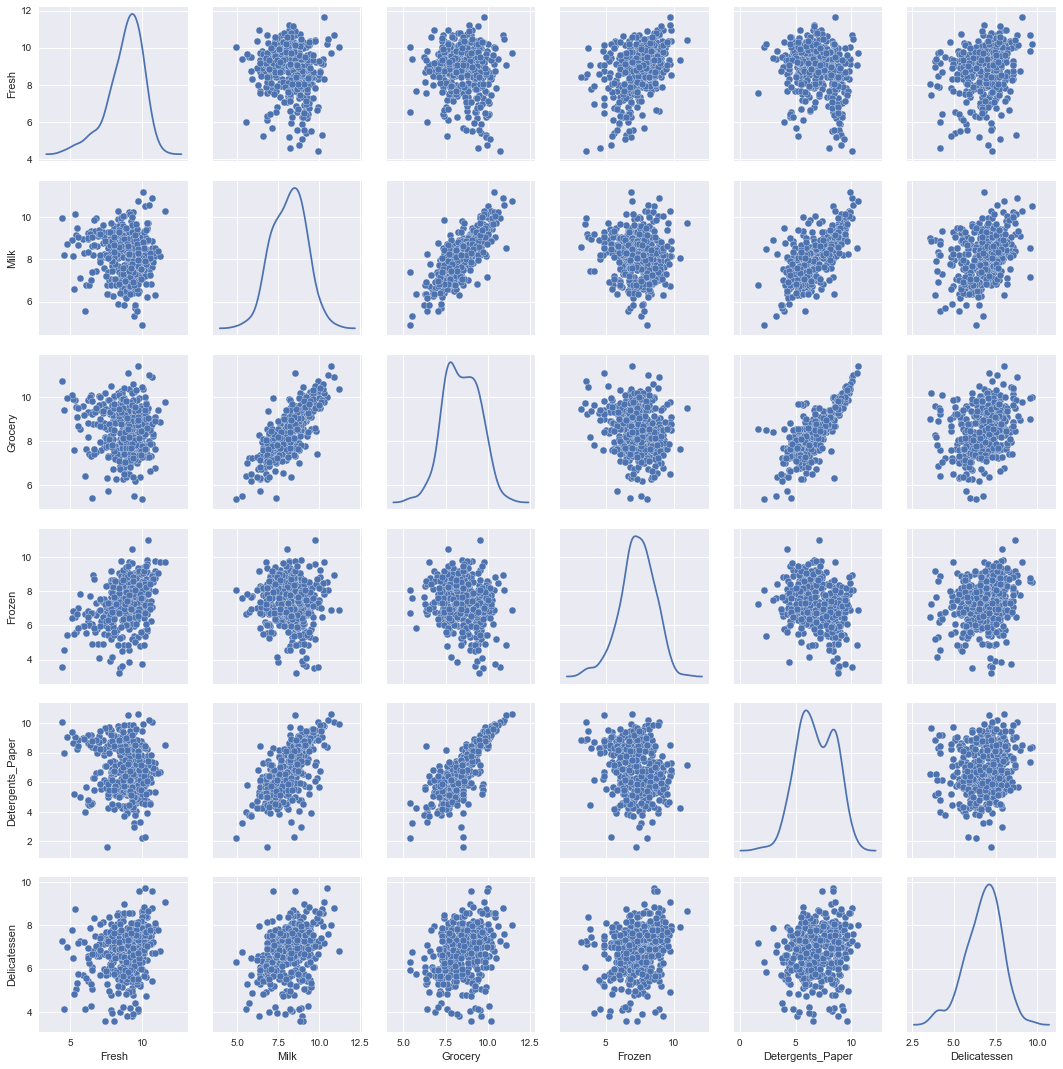

In [16]:
# Fresh      95   338   *66  218    96   357 | *65  412  353  *128  304  193  355  171  81  305
# Milk     *154    98 | 356   86
# Grocery   *75  *154 |
# Frozen    420    38   *65   57  145   429  175   264  439   325
# Deterg    *75   161 |
# Deli      109  *128  *142  187  233  *154  184  203  285  *289 | *66  137  343 | 183


# Select the indices for data points we wish to remove
outliers = [ 66, 75, 95, 96, 98, 109, 128, 142, 154, 161, 183, 184, 187, 203, 218, 233, 285, 289, 338, 357]

# Look at how much these outliers spend
print 'These outliers spend' , total_spend[outliers].sum() , '/' , total_spend.sum() , '=' , total_spend[outliers].astype(float).sum()/total_spend.astype(float).sum() , 'of the total.'

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

# Look at the scatter plots again with ouliers removed
# pd.scatter_matrix(good_data, alpha = 0.3, figsize = (14,10), diagonal = 'kde');
sns.pairplot(good_data, diag_kind='kde')
plt.show()

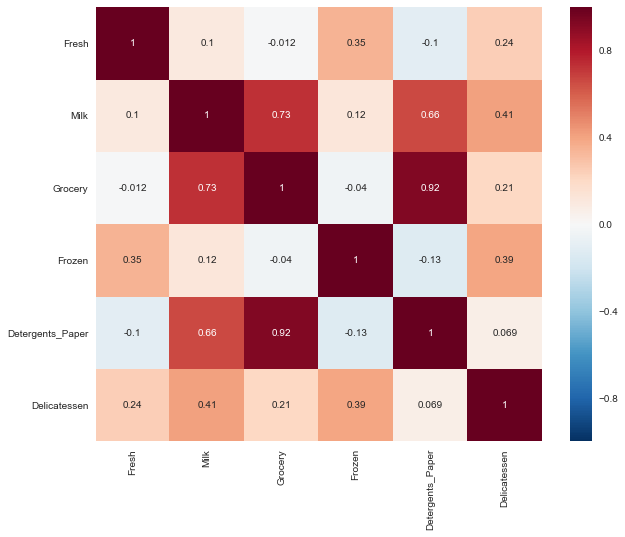

In [17]:
# sns.reset_orig()
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(data.corr(), annot=True)
plt.xticks(rotation=90)
plt.show()

#### Outlier analysis

Using Tukey's Method we identified 42 outliers. Of these 5 are outliers for more than one product category, we list these below:
*  65 - Fresh   & Frozen
*  66 - Fresh   & Delicatessen
*  75 - Grocery & Detergents_Paper
* 128 - Fresh   & Delicatessen
* 154 - Milk    & Grocery          & Delicatessen

We note that the outliers are mostly at the lower end of their product category. Some of the distributions appear to have a fat lower tail which makes determining which points might be outliers hard. We note, from the scatter plots, data points at the lower end of product category spending display more 'noise'. For example, the minimum value 1.098612 occurs numerous times for several product categories (four times for Delicatessen) with a much larger spread of values for the other product categories when compared to data points more central in the distribution.

Below we list the outliers for each product category in ascending order of value

|         | Fresh        |         | Milk      |         | Grocery  |         | Frozen    |         | Detergents_Paper |         | Delicatessen |
|---------|--------------|---------|-----------|---------|----------|---------|-----------|---------|-----------------|---------|--------------|
|**mean** |  8.730544    |         |  8.121047 |         | 8.441169 |         |  7.301396 |         | 6.785972        |         |  6.665133    |
| **50%** |  9.048286    |         |  8.196159 |         | 8.467057 |         |  7.330388 |         | 6.705018        |         |  6.872645    |
|  **95** |  1.098612    | **154** |  4.007333 |  **75** | 1.098612 | **420** |  3.218876 |  **75** | 1.098612          | **109** |  1.098612    |
| **338** |  1.098612    |  **98** |  4.718499 | **154** | 4.919981 |  **38** |  3.496508 | **161** | 1.098612          | **128** |  1.098612    |
|  **66** |  2.197225    | **356** |  4.89784  |         |          |  **65** |  3.583519 |         |                  | **142** |  1.098612    |
| **218** |  2.890372    |  **86** | 11.205013 |         |          |  **57** |  3.637586 |         |                  | **187** |  1.098612    |
|  **96** |  3.135494    |         |           |         |          | **145** |  3.73767  |         |                  | **233** |  1.94591     |
| **357** |  3.610918    |         |           |         |          | **429** |  3.850148 |         |                  | **154** |  2.079442    |
|  **65** |  4.442651    |         |           |         |          | **175** |  3.951244 |         |                  | **184** |  2.397895    |
| **412** |  4.574711    |         |           |         |          | **264** |  4.110874 |         |                  | **203** |  2.890372    |
| **353** |  4.762174    |         |           |         |          | **439** |  4.174387 |         |                  | **285** |  2.890372    |
| **128** |  4.941642    |         |           |         |          | **325** | 11.016479 |         |                  | **289** |  3.091042    |
| **304** |  5.081404    |         |           |         |          |         |           |         |                  |  **66** |  3.295837    |
| **193** |  5.192957    |         |           |         |          |         |           |         |                  | **137** |  3.583519    |
| **355** |  5.247024    |         |           |         |          |         |           |         |                  | **343** |  3.610918    |
| **171** |  5.298317    |         |           |         |          |         |           |         |                  | **183** | 10.777768    |
|  **81** |  5.389072    |         |           |         |          |         |           |         |                  |         |              |
| **305** |  5.493061    |         |           |         |          |         |           |         |                  |         |              ||


For each product category, we remove the outlier furthest to the left/right one at a time and look at the resulting scatter plots. We remove those points which lie outside of the general pattern of the data visually in the scatter plots. These points add noise and detract from the structure of the data. For example in PCA they will pull the mean lower and impact the covariances disproportionaltely.

With this in mind we remove the left most...
* six data points for the Fresh product category
* two data points for the Milk product category
* two data point for the Grocery product category
* zero data points for the Frozen product category
* two data points for the Detergents_Paper product category
* ten and right most data point for the Delicatessen product category

## 4 Feature Transformation

In this section we use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### 4.1 Principal Component Analysis

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. 

**Figure 4.1:** PCA components

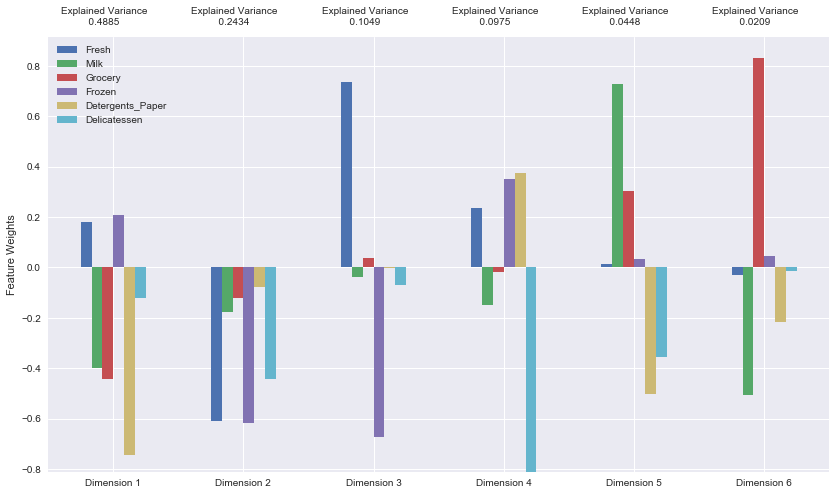

In [18]:
# Apply PCA to the good data with the same number of dimensions as features

from sklearn.decomposition import PCA

pca = PCA(n_components=6)
pca.fit(good_data)


def pca_results(good_data, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)


# Generate PCA results plot
display(Markdown('**Figure 4.1:** PCA components'))
pca_results = pca_results(good_data, pca)

**Table 4.1:** PCA components

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,0.180007,-0.399475,-0.442725,0.206257,-0.744804,-0.121394
1,-0.608551,-0.177452,-0.121724,-0.617268,-0.078288,-0.442956
2,0.735629,-0.036156,0.039544,-0.671503,-0.000687,-0.071144
3,0.234652,-0.149415,-0.018261,0.349595,0.376742,-0.811252
4,0.015242,0.727219,0.305430,0.033600,-0.500828,-0.354508
5,-0.028619,-0.506410,0.833063,0.046641,-0.215347,-0.013668


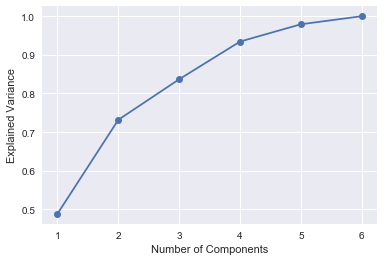

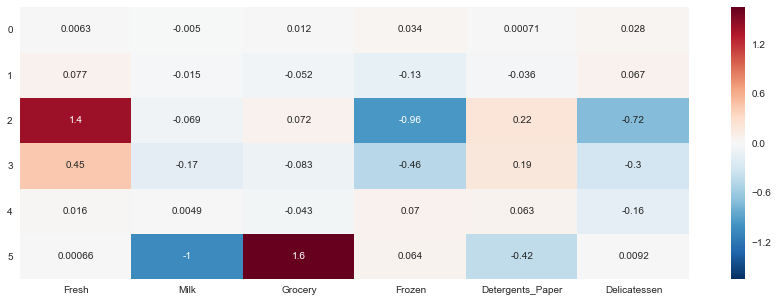

In [19]:
# PCA components
pca_df = pd.DataFrame(pca.components_, columns = features)
display(Markdown('**Table 4.1:** PCA components'))
display(pca_df)

# Plot explained variance again number of components
plt.plot(np.arange(1,7), np.cumsum(pca.explained_variance_ratio_), '-o')
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
plt.show()

# Calculate what the pca components are if we don't remove outliers
pca2 = PCA(n_components=6)
pca2.fit(log_data)
pca2_df = pd.DataFrame(pca2.components_, columns = features)

# Look at the difference between the PCA components with and without outliers removed in a heatmap
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.heatmap(pca_df-pca2_df, annot=True)
plt.yticks(rotation=0)
plt.show()

#### PCA analysis

73% of the variance is explained by the first two components and 94% of the variance is explained by the first four components.

We can view each product category as a dimension in a cartesian co-ordinate system. From this vantage point, each dimension in our PCA results is then a basis vector for a new set of co-ordinates, obtained via a linear transformation. Our new co-ordinates are centred at the mean of the data and are oriented such that, each component is a direction of maximal variation of our data, in descending order of magnitude. In other words, the first dimension is the direction of the axis of maximum variation. The second dimension is the direction of the axis of maximal variation of all possible directions orthogonal to the first axis. The third dimension is the direction of the axis of maximal variation of all possible directions orthogonal to the first two axes and so on.

Since the new co-ordinates are obtained by a linear transform, each principal component can be written as a linear combination of the original product categories. The components express the correlation to the original product categories, so a positive contribution from a product category means the component increases as that product category increases and a negative contribution means the component decreases as the product category increases. The size of the contribution indicates the relative size of that increase or decrease.

By the nature of our new co-ordinates (directions of maximal variation), the components not only express their correlation to the original product categories but the correlation between them too - they reveal spending patterns of the customers. Figure 4.1 and Table 4.1 above show the proportions of each product category spending, above (or below) the mean, which compose each principal component.

<u>First principal component in descending order of contribution from product categories</u>:

| Detergents_Paper	| Grocery | Milk | Frozen | Fresh | Delicatessen |
|-------------------|---------|------|--------|-------|--------------|
| 0.74              | 0.44    | 0.40 | -0.21  | -0.18 | 0.12         |

In our data we can see that the (first) principal component is made up of relatively large positive contributions from Detergents_Paper, Grocery and Milk (compared to the other three product categories). This is consistent with the feature relevance results in Table 2.1 and corroborates the positive correlation observed between them in the scatter plots earlier. One might consider these products household staples which are bought in similar proportions (approximately 74 : 44 : 40) above or below the mean (but different quantities) by a large proportion of the customers.

<u>Second principal component in descending order of contribution from product categories</u>:

| Frozen | Fresh | Delicatessen | Milk | Grocery | Detergents_Paper |
|--------|-------|--------------|------|---------|------------------|
| 0.62   | 0.61  | 0.44         | 0.18 | 0.12    | 0.0078           | 

The second principal component consists of large positive contributions from frozen and fresh product categories in similar proportions and delicatessen items a little less (62 : 61 : 44). This could be interpreted ad the second most popular combination of product categories bought together.

We note that the first two components seem to almost split the product categories into two groups. The first principal component contains mostly Detergents_Paper, Grocery and Milk which have a longer shelf life. The second component contains Frozen, Fresh, Delicatessen which have shorter shelf lives. Milk comes in many forms (fresh, long life, powdered) some of which require chilling and other which do not, this could explain why positive contributions from Milk can be found in both components.

The third and fourth principal components explain only 10% of the variance in our data each. We find they are much more sensitive to ouliers than the first two principal components.

<u>Third principal component in descending order of contribution from product categories</u>:

| Fresh | Frozen | Delicatessen | Grocery | Milk  | Detergents_Paper |
|-------|--------|--------------|---------|-------|------------------|
| -0.74 | 0.67   | 0.071        | -0.040  | 0.036 | 0.00069          |

The third principal component consists of offsetting Fresh and Frozen product contributions (-74 : 67) from the mean.

<u>Fourth principal component in descending order of contribution from product categories</u>:

| Delicatessen | Detergents_Paper | Frozen  | Fresh | Milk  | Grocery  |
|--------------|------------------|---------|-------|-------|----------|
| -0.82        | 0.38             | 0.34    | 0.23  | -0.15 | -0.018   |

The fourth principal component consists of a well below average contribution from spending on Delicatessen products and above average spending on Detergents_Paper and Frozen product categories (-82 : 38 : 34).

In [20]:
# Apply a PCA transformation to the sample log-data
pca_samples = pca.transform(log_samples)

# Display sample log-data points after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-5.2306,-1.9206,0.8221,0.0589,0.4742,0.2966
1,0.2945,2.1880,-0.5621,1.6343,-2.2787,-1.1659
2,0.6555,0.1208,-0.2198,-2.0304,-0.4566,-0.7756


### 4.2 Dimensionality Reduction

When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In [21]:
# Fit PCA to the good data using only two dimensions
pca = PCA(n_components=2)
pca.fit(good_data)

# Apply a PCA transformation the good data
reduced_data = pca.transform(good_data)

# Apply a PCA transformation to the sample log-data
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-5.2306,-1.9206
1,0.2945,2.1880
2,0.6555,0.1208


## 5 Clustering

In this section, we use K-Means and Gaussian Mixture Model clustering algorithms to identify the various customer segments hidden in the data. We then recover specific data points from the clusters to understand their significance by transforming them back to their original dimension and scale.

### 5.1 K-Means versus Gaussian Mixture Model clustering algorithm

K-Means can be described as a hard boundary version of a Gaussian Mixture Model (GMM). The algorithms are very similar in that both algorithms require the number of clusters to be input, both algorithms recursively determine the relation of each data point to the cluster centres and then adjust the location of the cluster centres to the expected location based on those relations. The algorithms differ in that K-Means determines a single cluster centre to which each data point belongs by that which is closest. In other words each point belongs to the closest cluster centre with probability one and to the other cluster centres with probability zero. GMMs on the other hand assume each cluster centre generates data points according to a Gaussian distribution so each data point belongs to each and every cluster centre with some non-zero probability.

K-means is a simpler algorithm and is fast compared to Gaussian Mixture Model since it does not require calculation of probabilities or covariances; though that speed difference is inconsequential for our data set size and shape.

Some disadvantages of K-means over Gaussian Mixture Models are that K-means does not model overlapping clusters and does not take into account the shape of the data by allowing for different covariance matricies in different clusters as GMM does. This means that it does not preform well in cases where cluster centres are very close or where the shape of the data is more important than the distance from the cluster centre in identifying clusters.

Looking at our scatter plots, we can see overlapping pairs of clusters in some of the scatter plots, and clusters which are not circular in shape, however none of these seem to occur in such a way that GMM would give us significantly different results to K-means.

### 5.2 Creating Clusters

Since it is unclear what structure exists in the data — if any, we try a range of cluster numbers. We quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In [22]:
# Apply clustering algorithms of choice to the reduced data

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

scores = np.zeros((5,2))

for n in range(2,7):
    clusterer = KMeans(n_clusters=n, random_state=0)
    
    # Predict the cluster for each data point
    preds = clusterer.fit_predict(reduced_data)

    # Find the cluster centers
    centers = clusterer.cluster_centers_

    # Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    scores[n-2,0] = silhouette_score(reduced_data, preds)

for n in range(2,7):
    clusterer = GaussianMixture(n_components=n, random_state=0)
    
    # Predict the cluster for each data point
    preds = clusterer.fit_predict(reduced_data)

    # Find the cluster centers
    centers = clusterer.means_

    # Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    scores[n-2,1] = silhouette_score(reduced_data, preds)

scores_df = pd.DataFrame( data = scores, index = range(2,7), columns = ['KMeans', 'GMM'])
display(scores_df)

,KMeans,GMM
2,0.442307,0.442881
3,0.347829,0.390857
4,0.335875,0.305561
5,0.361746,0.292672
6,0.364658,0.316478


#### Clustering analysis

Gaussian Mixture Model with 2 clusters has the best `silhouette_score`, though there is little difference between the score for this model and KMeans. This is consistent with our scatter plots and observed bi-modal distributions.

### 5.3 Cluster Visualization

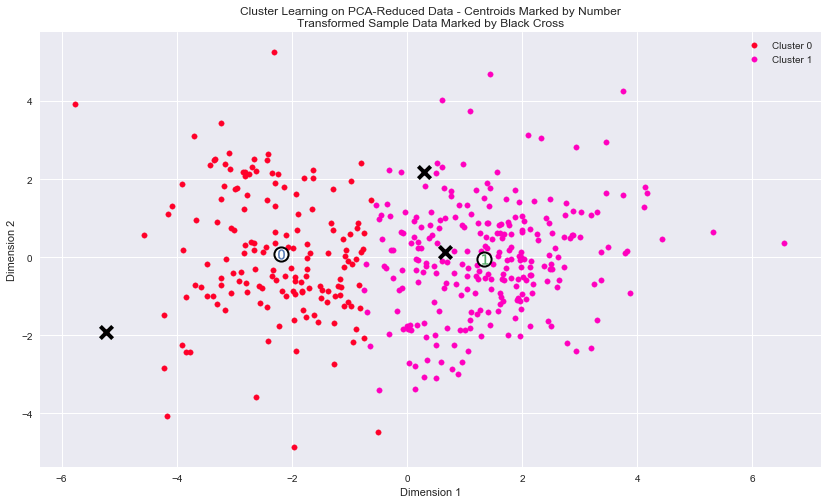

In [23]:
# Choose GMM with 2 components
clusterer = GaussianMixture(n_components=2, random_state=0)

# Predict the cluster for each data point
preds = clusterer.fit_predict(reduced_data)

# Find the cluster centers
centers = clusterer.means_


def cluster_results(reduced_data, preds, centers, pca_samples):
    '''
    Visualizes the PCA-reduced cluster data in two dimensions
    Adds cues for cluster centers and student-selected sample data
    '''

    predictions = pd.DataFrame(preds, columns = ['Cluster'])
    plot_data = pd.concat([predictions, reduced_data], axis = 1)

    # Generate the cluster plot
    fig, ax = plt.subplots(figsize = (14,8))

    # Color map
    cmap = cm.get_cmap('gist_rainbow')

    # Color the points based on assigned cluster
    for i, cluster in plot_data.groupby('Cluster'):   
        cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                     color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

    # Plot centers with indicators
    for i, c in enumerate(centers):
        ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
                   alpha = 1, linewidth = 2, marker = 'o', s=200);
        ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

    # Plot transformed sample points 
    ax.scatter(x = pca_samples[:,0], y = pca_samples[:,1], \
               s = 150, linewidth = 4, color = 'black', marker = 'x');

    # Set plot title
    ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");


# Display the results of the clustering from implementation
cluster_results(reduced_data, preds, centers, pca_samples)

### 5.4 Data Recovery

Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In [24]:
# Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = features)
true_centers.index = segments
display(true_centers)

mean_centred_df = true_centers - data.mean()
size = (mean_centred_df**2.0).sum(axis=1)**0.5
display(mean_centred_df.div(size, axis=0))

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,4413.0,8229.0,12413.0,915.0,4814.0,1104.0
Segment 1,9103.0,2063.0,2650.0,2074.0,352.0,767.0


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,-0.791218,0.253690,0.465277,-0.224929,0.201526,-0.043889
Segment 1,-0.379117,-0.488505,-0.693682,-0.130581,-0.330989,-0.099169


#### Segment analysis

Segment 0:

| Grocery | Milk | Detergents_Paper | Delicatessen | Frozen | Fresh  |
|---------|------|------------------|--------------|--------|--------|
| 0.47    | 0.25 | 0.20             | -0.044       | -0.22  | -0.79  |

This representative customer spends above average on Grocery, Milk and Detergents_Paper product categories (cupboard or non-chilled items) and below average on Delicatessen, Frozen and Fresh products. I would guess any data point very close to this cluster centre would likely be a convenience store and the customer segment likely represents retail stores.

Segment 1:

| Delicatessen | Frozen | Detergents_Paper | Fresh | Milk  | Grocery |
|--------------|--------|------------------|-------|-------|---------|
| -0.10        | -0.13  | -0.33            | -0.38 | -0.49 | -0.69   |

This representative customer spends below average on all product categories but spends more on Delicatessen and Frozen products relatively speaking. Any point close to this cluster centre might represent a fast food restaurant while the cluster itself contains restaurants and hotels.

We note that our cluster centres have significantly different values along our first principal component but have similar values in our second principal component.

In [25]:
# Display the predictions for our sample points
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred

Sample point 0 predicted to be in Cluster 2
Sample point 1 predicted to be in Cluster 5
Sample point 2 predicted to be in Cluster 1


#### Sample analysis

On selecting them, I guessed my sample points were a convenience store, a guesthouse and a sandwich shop. Based on the clusters we found, these are best represented by segments 0, 1 and 1 respectively. The sample points were predicted to belong to clusters 0, 1 and 1 respectively. The model prediction is consistent with my description of the customers being a convenience store and fast food or sandwich bar style restaurant.

## 6 Conclusion

### 6.1 How this information can be used

#### A/B testing

[A/B tests](https://en.wikipedia.org/wiki/A/B_testing) can be used as a way to assess the impact (on some 'output variable') of making a small change, or choosing between two possible variants of an 'input variable' to optimise an output variable. The basic idea is to carry out an experiment on two test groups where the two groups are sampled randomly from the same population and differ only by one binary 'input variable'. We can then measure the output variable and use hypothesis testing to understand if any differences between the test groups are statistically significant and ultimately make a choice about whether to make the change or which variant to choose.

Some typical examples of where A/B testing is used:
* To decide between two variants of a web page. In this case the binary input variable would be the web page itself (variant A and variant B) and the output variable might be the proportion of customers in the test group which click on the desired link.
* To measure the effectiveness of a drug, the binary input variable here would be whether the patient is given the drug (test group A) or a placebo (test group B - the control group) and the output variable could be the average change in some health metric (which indicates the level of illness of the patient) after the drug (or placebo) is administered.

Take an example where the reailer is interested in making is a reduction in the delivery service from five to three days a week. We have found our customers fall into one of two possible segments (0 or 1). In order to identify which segment would be more affected more by a change in the delivery service we could sample independently from each cluster to create the two test groups. Test group A would be a sample of customers from segment 0 and test group B a sample of customers from segment 1. Here the binary input variable is the customer segment to which the customer belongs. We could then implement the change in delivery service for both test sets and see how their spending patterns change in response. So our output variable might me the average change in spending for the test group across the product categories between the week/month before and after the change in the delivery service.

#### Further supervised learning analysis

Apart from the additional insight we have gained into the nature of our data and the driving features, the structure we have found in the data can be used to reduce noise and the dimensionality of the data we have. That is, we could use the first say two principal componants instead of our original six product categories. This would enable us to get more effective results with smaller datasets to train our supervised learning algorithm on. Along with our principal componants as new features we could also use the clusters we have found as a new feature.

### 6.2 Visualizing Underlying Distributions

At the beginning of this project, we excluded the `'Channel'` and `'Region'` features from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier on to the original dataset.

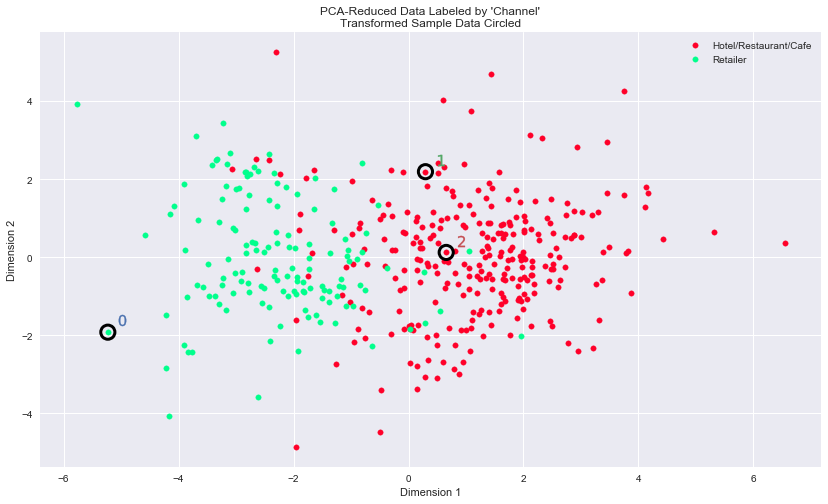

In [26]:
def channel_results(reduced_data, outliers, pca_samples):
    '''
    Visualizes the PCA-reduced cluster data in two dimensions using the full dataset
    Data is labeled by "Channel" and cues added for student-selected sample data
    '''

    # Check that the dataset is loadable
    try:
        full_data = pd.read_csv("customers.csv")
    except:
        print "Dataset could not be loaded. Is the file missing?"
        return False

    # Create the Channel DataFrame
    channel = pd.DataFrame(full_data['Channel'], columns = ['Channel'])
    channel = channel.drop(channel.index[outliers]).reset_index(drop = True)
    labeled = pd.concat([reduced_data, channel], axis = 1)

    # Generate the cluster plot
    fig, ax = plt.subplots(figsize = (14,8))

    # Color map
    cmap = cm.get_cmap('gist_rainbow')

    # Color the points based on assigned Channel
    labels = ['Hotel/Restaurant/Cafe', 'Retailer']
    grouped = labeled.groupby('Channel')
    for i, channel in grouped:   
        channel.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                     color = cmap((i-1)*1.0/2), label = labels[i-1], s=30);

    # Plot transformed sample points   
    for i, sample in enumerate(pca_samples):
        ax.scatter(x = sample[0], y = sample[1], \
                   s = 200, linewidth = 3, color = 'black', marker = 'o', facecolors = 'none');
        ax.scatter(x = sample[0]+0.25, y = sample[1]+0.3, marker='$%d$'%(i), alpha = 1, s=125);

    # Set plot title
    ax.set_title("PCA-Reduced Data Labeled by 'Channel'\nTransformed Sample Data Circled");


# Display the clustering results based on 'Channel' data
channel_results(reduced_data, outliers, pca_samples)

#### Comparison of our customer segments with 'Channel' data

Our clusters compare well with the given underlying distribution of Hotel/Restaurant/Cafe and Retailer customer types. We found two clusters in our data and these correspond to the segments above, that is, cluster 0 aligns roughly with Retailers and cluster 1 aligns roughly with Hotel/Restaurant/Cafe, this is consistent with our guess.

We note that as mentioned above the clusters are more overlapping than was obvious from the clusters we found earlier and the cluster centres are closer than predicted but the general pattern is similar. Customers who score large and negaive values of the principal components are most likely Retailers and those who score large and negative values are most likely a Hotel, Restaurant or Cafe. This is consistent with the way we defined our customer segments earlier.